# Normalising Flow

In [1]:
from astropy.io import fits
import os

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.pyplot as plt
import sklearn.decomposition
import seaborn as sn
import pickle
if("Cluster_analysis" in os.getcwd()):
    os.chdir("../Data_handling")

from RealNVP import FlowGMM
from gaia_query import gaia_cone, bailer_jones_cone, concatenate_gaia_bailer
from vae import Encoder,Decoder, VAE , loss_function, model_train
from sp_vae import ModelVAE,model_trains
from gmm_torch import GaussianMixture

os.chdir("../Cluster_analysis")
os.getcwd()

'/Users/mattocallaghan/GES/Cluster_analysis'

# Normalising Flows

In [2]:
sn.set_style('darkgrid') # darkgrid, white grid, dark, white and ticks
plt.rc('axes', titlesize=18)     # fontsize of the axes title
plt.rc('axes', labelsize=14)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=13)    # fontsize of the tick labels
plt.rc('ytick', labelsize=13)    # fontsize of the tick labels
plt.rc('legend', fontsize=13)    # legend fontsize
plt.rc('font', size=13)  

In [3]:
os.chdir('../cluster_files')
nf_data=pd.read_csv('vae_data.csv')
os.chdir('../Cluster_analysis')

### For now we just dropna instead of dealing with missing values.


In [4]:
nf_data=nf_data.dropna().reset_index()

In [5]:
nf_data

,index,Unnamed: 0,bp_rp,mean_absolute_mag_g_band,prob,ra,dec,parallax,VRAD,pmra,pmdec,phot_g_mean_mag,bp_g,g_rp,rgeo
0,0,0,1.330919,5.377983,2.274159e-105,282.565031,-6.258065,0.558562,30.64,0.776237,-6.756839,16.820326,0.590866,0.740053,1942.98157
1,1,1,1.458172,3.869186,1.353626e-97,282.583418,-6.192254,0.376980,105.47,-1.612175,-4.640347,17.810553,0.413675,1.044496,6141.48389
2,2,2,1.252724,4.753740,6.489013e-05,282.592885,-6.329504,0.375033,39.07,-2.393408,-4.043109,16.887486,0.575531,0.677193,2671.46338
3,3,3,1.342695,4.844798,1.030781e-289,282.596724,-6.241452,0.523459,-43.21,-3.040533,-0.931751,16.224398,0.585712,0.756983,1887.64343
4,4,4,1.233818,4.017714,4.646607e-49,282.596739,-6.257442,0.395225,-5.76,-0.711199,-4.404408,15.882403,0.529069,0.704749,2360.14062
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
24570,25777,25777,1.685307,3.015978,1.672580e-29,282.788470,-6.007469,0.030766,0.00,-2.850967,-5.665195,17.267374,0.790930,0.894377,7084.01074
24571,25778,25778,1.605724,4.919543,0.000000e+00,282.780248,-6.007047,0.449862,0.00,1.577184,3.119071,16.531607,0.720057,0.885668,2100.93555
24572,25779,25779,2.963137,2.587664,3.309269e-07,282.775456,-6.005157,0.002803,0.00,-1.806624,-4.939151,17.039620,1.733685,1.229452,7769.46533
24573,25780,25780,1.505640,3.746492,2.134436e-18,282.703295,-6.011748,0.209325,0.00,-3.147602,-4.699169,17.225449,0.667429,0.838211,4963.53955


### Data preprocessing

In [6]:
from sklearn.preprocessing import  MinMaxScaler
import torch
scaler=MinMaxScaler()
#column_names=['pmra', 'pmdec',
       #'rgeo','ra','dec']
column_names=['ra','dec','pmra','pmdec','mean_absolute_mag_g_band','bp_g','g_rp','bp_rp']
column_names=['mean_absolute_mag_g_band','bp_rp','ra','dec','rgeo','g_rp','pmra','pmdec']
scaled_data=scaler.fit_transform(nf_data[column_names].values)

# Noramlising Flow Model

In [7]:
batch_size = 4915 #617 #factor for 1090
lr = 1e-3
epochs = 100


In [8]:
# Target distribution means
r = 10
means = torch.tensor([[-r for i in range(len(column_names))], [r for i in range(len(column_names))], [(-1)**i*r for i in range(len(column_names))]])


from torch.utils.data import DataLoader
# Define distribution. 
from sklearn import cluster, datasets, mixture
from sklearn.preprocessing import StandardScaler


X=DataLoader(torch.tensor(scaled_data).float(),batch_size=batch_size) 
model = FlowGMM(layers=2,n_features=scaled_data[0].shape[-1],mixture_components=3,hidden_dims=[50,5],d=2,means=means)

# Training hyperparameters.
learning_rate = 1e-4
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)



In [9]:
plot_loss=[]
plotll=[]
plotdet=[]
# Iterate over the number of iterations.
model.train()

for epoch in range(epochs):    
        overall_loss = 0
        for batch_idx, x in enumerate(X):

            x = x.view(batch_size, len(x[0]))
            #x = x.to(DEVICE)
            
            optimizer.zero_grad()

            y,gmm,loss,ll,det = model(x)

            
            
            overall_loss += loss.item()
            
            loss.backward()
            optimizer.step()
            
        plot_loss.append(loss)   
        plotll.append(ll)  
        plotdet.append(det)   
        print("\tEpoch", epoch + 1, "complete!", "\tAverage Loss: ", overall_loss / (batch_idx*batch_size))
        print("Overall Loss: ", overall_loss)
    
print("Finish!!")


	Epoch 1 complete! 	Average Loss:  0.0022315066561694064
Overall Loss:  43.87142086029053
	Epoch 2 complete! 	Average Loss:  0.00218859026900143
Overall Loss:  43.027684688568115
	Epoch 3 complete! 	Average Loss:  0.002258854407138766
Overall Loss:  44.409077644348145
	Epoch 4 complete! 	Average Loss:  0.0022359792237849345
Overall Loss:  43.959351539611816
	Epoch 5 complete! 	Average Loss:  0.0022169703505895387
Overall Loss:  43.58563709259033
	Epoch 6 complete! 	Average Loss:  0.0022051115365867577
Overall Loss:  43.352492809295654
	Epoch 7 complete! 	Average Loss:  0.0022235310089794326
Overall Loss:  43.714619636535645
	Epoch 8 complete! 	Average Loss:  0.0022268143942009277
Overall Loss:  43.779170989990234
	Epoch 9 complete! 	Average Loss:  0.002212514203053161
Overall Loss:  43.49802923202515
	Epoch 10 complete! 	Average Loss:  0.002186012340828943
Overall Loss:  42.97700262069702
	Epoch 11 complete! 	Average Loss:  0.0021678029581343535
Overall Loss:  42.61900615692139
	Epoch 

In [10]:
model.eval()

FlowGMM(
  (prior): GaussianMixture()
  (s_net): ModuleList(
    (0): Sequential(
      (0): Linear(in_features=2, out_features=50, bias=True)
      (1): ReLU()
      (2): Linear(in_features=50, out_features=5, bias=True)
      (3): ReLU()
      (4): Linear(in_features=5, out_features=6, bias=True)
    )
    (1): Sequential(
      (0): Linear(in_features=2, out_features=50, bias=True)
      (1): ReLU()
      (2): Linear(in_features=50, out_features=5, bias=True)
      (3): ReLU()
      (4): Linear(in_features=5, out_features=6, bias=True)
    )
  )
  (t_net): ModuleList(
    (0): Sequential(
      (0): Linear(in_features=2, out_features=50, bias=True)
      (1): ReLU()
      (2): Linear(in_features=50, out_features=5, bias=True)
      (3): ReLU()
      (4): Linear(in_features=5, out_features=6, bias=True)
    )
    (1): Sequential(
      (0): Linear(in_features=2, out_features=50, bias=True)
      (1): ReLU()
      (2): Linear(in_features=50, out_features=5, bias=True)
      (3): ReLU(

In [11]:
import matplotlib.pyplot as plt
for i in range (len(plot_loss)):
    plot_loss[i]=plot_loss[i].detach().numpy()
    plotll[i]=plotll[i].detach().numpy()
    plotdet[i]=plotdet[i].detach().numpy()


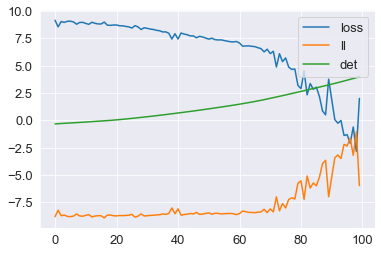

In [12]:
plt.plot(plot_loss,label='loss')
plt.plot(plotll,label='ll')
plt.plot(plotdet,label='det')
plt.legend()
plt.show()

In [13]:
y,gmm,loss,ll,det = model(torch.tensor(scaled_data).float())
probs=gmm.predict_proba(y).detach().numpy()
y=y.detach().numpy()


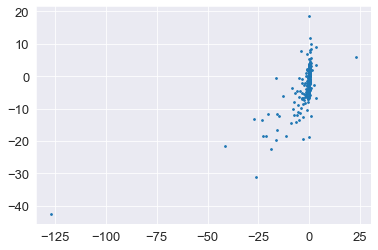

In [14]:
plt.scatter(y.transpose()[0],y.transpose()[1],s=3)

(array([ 5514.,   491.,   390.,   353.,   338.,   391.,   414.,   607.,
         1087., 14988.]),
 array([0.        , 0.09996583, 0.19993167, 0.2998975 , 0.39986333,
        0.49982917, 0.599795  , 0.69976085, 0.79972667, 0.89969254,
        0.99965835], dtype=float32),
 <BarContainer object of 10 artists>)

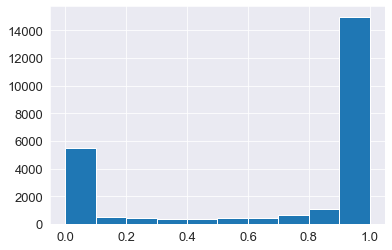

In [15]:
plt.hist(probs.transpose()[2])

In [16]:
column=[i for i in range(probs.shape[-1])]
df=pd.DataFrame(data=probs,columns=column)
plotdf=pd.concat([nf_data,df],axis=1)

In [17]:
plotdf

,index,Unnamed: 0,bp_rp,mean_absolute_mag_g_band,prob,ra,dec,parallax,VRAD,pmra,pmdec,phot_g_mean_mag,bp_g,g_rp,rgeo,0,1,2
0,0,0,1.330919,5.377983,2.274159e-105,282.565031,-6.258065,0.558562,30.64,0.776237,-6.756839,16.820326,0.590866,0.740053,1942.98157,0.002823,3.040446e-16,9.971772e-01
1,1,1,1.458172,3.869186,1.353626e-97,282.583418,-6.192254,0.376980,105.47,-1.612175,-4.640347,17.810553,0.413675,1.044496,6141.48389,0.315079,1.593845e-12,6.849208e-01
2,2,2,1.252724,4.753740,6.489013e-05,282.592885,-6.329504,0.375033,39.07,-2.393408,-4.043109,16.887486,0.575531,0.677193,2671.46338,0.001050,1.548515e-16,9.989499e-01
3,3,3,1.342695,4.844798,1.030781e-289,282.596724,-6.241452,0.523459,-43.21,-3.040533,-0.931751,16.224398,0.585712,0.756983,1887.64343,0.003852,2.861058e-16,9.961483e-01
4,4,4,1.233818,4.017714,4.646607e-49,282.596739,-6.257442,0.395225,-5.76,-0.711199,-4.404408,15.882403,0.529069,0.704749,2360.14062,0.002469,6.263420e-15,9.975306e-01
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
24570,25777,25777,1.685307,3.015978,1.672580e-29,282.788470,-6.007469,0.030766,0.00,-2.850967,-5.665195,17.267374,0.790930,0.894377,7084.01074,0.007537,2.886128e-11,9.924631e-01
24571,25778,25778,1.605724,4.919543,0.000000e+00,282.780248,-6.007047,0.449862,0.00,1.577184,3.119071,16.531607,0.720057,0.885668,2100.93555,0.023772,1.755614e-14,9.762280e-01
24572,25779,25779,2.963137,2.587664,3.309269e-07,282.775456,-6.005157,0.002803,0.00,-1.806624,-4.939151,17.039620,1.733685,1.229452,7769.46533,0.999989,9.370175e-06,1.348900e-06
24573,25780,25780,1.505640,3.746492,2.134436e-18,282.703295,-6.011748,0.209325,0.00,-3.147602,-4.699169,17.225449,0.667429,0.838211,4963.53955,0.003454,2.838391e-13,9.965459e-01


In [28]:
j=2
data_for_hr1_full=plotdf[plotdf[j]>0.9]
data_for_hr2_full=plotdf[plotdf['prob']>0.9]
both_solution=data_for_hr1_full[plotdf['prob']>0.9]
data_for_hr1_full=data_for_hr1_full[data_for_hr1_full['prob']<=0.9]
data_for_hr2_full=data_for_hr2_full[data_for_hr2_full[j]<=0.9]

/var/folders/tm/gnjj0w_d6vj9x6q_ww3f6jsw0000gn/T/ipykernel_13404/1539325689.py:4: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  both_solution=data_for_hr1_full[plotdf['prob']>0.9]


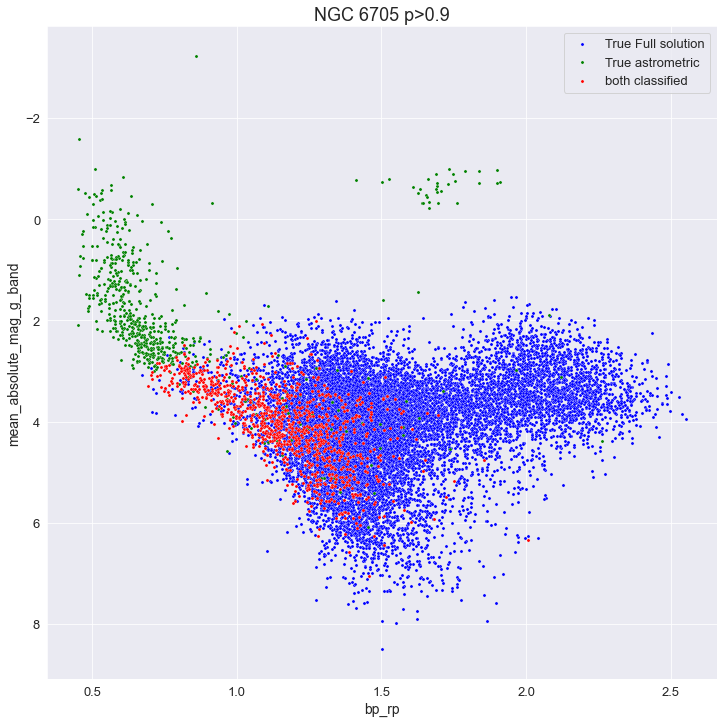

In [29]:
f, axes = plt.subplots(1, 1)
f.set_figheight(12)
f.set_figwidth(12)

scatter=data_for_hr1_full
sn.scatterplot(x=scatter['bp_rp'],y=scatter['mean_absolute_mag_g_band'],ax=axes,s=10,label='True Full solution',color='b')

scatter=data_for_hr2_full
sn.scatterplot(x=scatter['bp_rp'],y=scatter['mean_absolute_mag_g_band'],ax=axes,label='True astrometric',s=10,color='g')

scatter=both_solution
sn.scatterplot(x=scatter['bp_rp'],y=scatter['mean_absolute_mag_g_band'],ax=axes,label='both classified',s=10,color='red')

#axes.set_xlim(0,2.5)
axes.invert_yaxis()
plt.legend()
axes.set_title("NGC 6705 p>0.9")
plt.show()

In [30]:
gmm=GaussianMixture(n_components=3,n_features=scaled_data.shape[-1],init_params='random')
gmm.fit(torch.tensor(scaled_data).float())

In [31]:
p=gmm.predict_proba(torch.tensor(scaled_data).float()).detach().numpy()

(array([13126.,  1398.,   887.,   660.,   558.,   406.,   436.,   510.,
          736.,  5857.]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ],
       dtype=float32),
 <BarContainer object of 10 artists>)

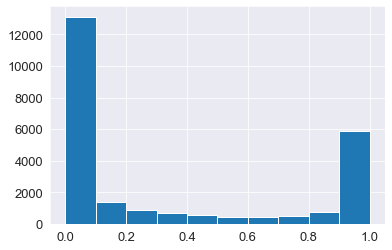

In [32]:
plt.hist(p.transpose()[2])